# 3. Propiedades estadísticas del lenguaje

## Objetivos

- Mostrar el uso de CFG y derivados
    - Ejemplos de parseo de dependencias
- Ejemplificar etiquetado NER usando bibliotecas existentes
- Explorar propiedades estadísticas del lenguaje natural y observar los siguientes fenomenos:
    - La distribución de Zipf
    - La distribución de Heap

## Perspectivas formales

- Fueron el primer acercamiento al procesamiento del lenguaje natural. Sin embargo tienen varias **desventajas**
- Requieren **conocimiento previo de la lengua**
- Las herramientas son especificas de la lengua
- Los fenomenos que se presentan son muy amplios y difícilmente se pueden abarcar con reglas formales (muchos casos especiales)
- Las reglas tienden a ser rigidas y no admiten incertidumbre en el resultado

### Sintaxis

![](https://imgs.xkcd.com/comics/formal_languages_2x.png)

**[audience looks around] 'What just happened?' 'There must be some context we're missing.'**

#### Parsing basado en reglas

- Gramaticas libres de contexto:

$G = (T, N, O, R)$
* $T$ símbolos terminales.
* $N$ símbolos no terminales.
* $O$ simbolo inicial o nodo raíz.
* $R$ reglas de la forma $X \longrightarrow \gamma$ donde $X$ es no terminal y $\gamma$ es una secuencia de terminales y no terminales

In [152]:
import nltk
import pandas as pd
import numpy as np

In [2]:
plain_grammar = """
S -> NP VP
NP -> Det N | Det N PP | 'I'
VP -> V NP | VP PP
PP -> P NP
Det -> 'an' | 'my'
N -> 'elephant' | 'pajamas'
V -> 'shot'
P -> 'in'
"""

In [6]:
grammar = nltk.CFG.fromstring(plain_grammar)
# Cambiar analizador y trace
analyzer = nltk.ChartParser(grammar)

sentence = "I shot an elephant in my pajamas".split()
trees = analyzer.parse(sentence)

In [7]:
for tree in trees:
    print(tree, type(tree))
    print('\nBosquejo del árbol:\n')
    print(tree.pretty_print(unicodelines=True, nodedist=1))

(S
  (NP I)
  (VP
    (VP (V shot) (NP (Det an) (N elephant)))
    (PP (P in) (NP (Det my) (N pajamas))))) <class 'nltk.tree.tree.Tree'>

Bosquejo del árbol:

     S                                       
 ┌───┴──────────────┐                         
 │                  VP                       
 │        ┌─────────┴──────────┐              
 │        VP                   PP            
 │   ┌────┴───┐            ┌───┴───┐          
 │   │        NP           │       NP        
 │   │    ┌───┴─────┐      │   ┌───┴─────┐    
 NP  V   Det        N      P  Det        N   
 │   │    │         │      │   │         │    
 I  shot  an     elephant  in  my     pajamas

None
(S
  (NP I)
  (VP
    (V shot)
    (NP (Det an) (N elephant) (PP (P in) (NP (Det my) (N pajamas)))))) <class 'nltk.tree.tree.Tree'>

Bosquejo del árbol:

     S                                   
 ┌───┴──────────┐                         
 │              VP                       
 │   ┌──────────┴──────┐                  


## Perspectiva estadística

- Puede integrar aspectos de la perspectiva formal
- Lidia mejor con la incertidumbre y es menos rigida que la perspectiva formal
- No requiere conocimiento profundo de la lengua. Se pueden obtener soluciones de forma no supervisada

## Modelos estadísticos

- Las **frecuencias** juegan un papel fundamental para hacer una descripción acertada del lenguaje
- Las frecuencias nos dan información de la **distribución de tokens**, de la cual podemos estimar probabilidades.
- Existen **leyes empíricas del lenguaje** que nos indican como se comportan las lenguas a niveles estadísticos
- A partir de estas leyes y otras reglas estadísticas podemos crear **modelos del lenguaje**; es decir, asignar probabilidades a las unidades lingüísticas

### Probabilistic Context Free Grammar

In [8]:
taco_grammar = nltk.PCFG.fromstring("""
O    -> FN FV     [0.7]
O    -> FV FN     [0.3]
FN   -> Sust      [0.6]
FN   -> Det Sust  [0.4]
FV   -> V FN      [0.8]
FV   -> FN V      [0.2]
Sust -> 'Juan'    [0.5]
Sust -> 'tacos'   [0.5]
Det  -> 'unos'    [1.0]
V    -> 'come'    [1.0]
""")
viterbi_parser = nltk.ViterbiParser(taco_grammar)

In [9]:
sentences = [
    "Juan come unos tacos",
    "unos tacos Juan come"
]
for sent in sentences:
    for tree in viterbi_parser.parse(sent.split()):
        print(tree)
        print("Versión bosque")
        tree.pretty_print(unicodelines=True, nodedist=1)

(O
  (FN (Sust Juan))
  (FV (V come) (FN (Det unos) (Sust tacos)))) (p=0.0336)
Versión bosque
           O                
 ┌─────────┴───┐             
 │             FV           
 │    ┌────────┴────┐        
 FN   │             FN      
 │    │        ┌────┴────┐   
Sust  V       Det       Sust
 │    │        │         │   
Juan come     unos     tacos

(O
  (FN (Det unos) (Sust tacos))
  (FV (FN (Sust Juan)) (V come))) (p=0.0084)
Versión bosque
                O               
      ┌─────────┴────────┐       
      │                  FV     
      │             ┌────┴───┐   
      FN            FN       │  
 ┌────┴────┐        │        │   
Det       Sust     Sust      V  
 │         │        │        │   
unos     tacos     Juan     come



### Parseo de dependencias

Un parseo de dependencias devuelve las dependencias que se dan entre los tokens de una oración. Estas dependencias suelen darse entre pares de tokens. Esto es, que relaciones tienen las palabras con otras palabras.

##### Freeling - https://nlp.lsi.upc.edu/freeling/demo/demo.php

In [8]:
import spacy
from spacy import displacy

In [15]:
!python -m spacy download es_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 14.1 MB/s  0:00:35:00:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [37]:
nlp = spacy.load("es_core_news_lg")

In [38]:
doc = nlp("La niña come un suani")

In [21]:
displacy.render(doc, style="dep")

In [39]:
for chunk in doc.noun_chunks:
    print("text::", chunk.text)
    print("root::", chunk.root.text)
    print("root dep::", chunk.root.dep_)
    print("root head::", chunk.root.head.text)
    print("="*10)

text:: La niña
root:: niña
root dep:: nsubj
root head:: come
text:: un suani
root:: suani
root dep:: obj
root head:: come


In [23]:
for token in doc:
    print("token::", token.text)
    print("dep::", token.dep_)
    print("head::", token.head.text)
    print("head POS::", token.head.pos_)
    print("CHILDS")
    print([child for child in token.children])
    print("="*10)

token:: La
dep:: det
head:: niña
head POS:: NOUN
CHILDS
[]
token:: niña
dep:: nsubj
head:: come
head POS:: VERB
CHILDS
[La]
token:: come
dep:: ROOT
head:: come
head POS:: VERB
CHILDS
[niña, suani]
token:: un
dep:: det
head:: suani
head POS:: PROPN
CHILDS
[]
token:: suani
dep:: obj
head:: come
head POS:: VERB
CHILDS
[un]


#### Named Entity Recognition (NER)

El etiquetado NER consiste en identificar "objetos de la vida real" como organizaciones, paises, personas, entre otras y asignarles su etiqueta correspondiente. Esta tarea es del tipo *sequence labeling* ya que dado un texto de entrada el modelo debe identificar los intervalos del texto y etiquetarlos adecuadamente con la entidad que le corresponde. Veremos un ejemplo a continuación.

In [24]:
!pip install datasets

In [3]:
from datasets import load_dataset

In [4]:
from huggingface_hub import login
login()

In [5]:
!hf auth whoami

user:  umoqnier
orgs:  ElotlMX,somosnlp-hackathon-2022,somosnlp,UNAMMexico


In [31]:
data = load_dataset("MarcOrfilaCarreras/spanish-news")

README.md: 0.00B [00:00, ?B/s]

data.csv:   0%|          | 0.00/44.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10200 [00:00<?, ? examples/s]

In [32]:
data?

Type:        DatasetDict
String form:
DatasetDict({
    train: Dataset({
        features: ['language', 'category', 'newspaper', 'hash', 'text'],
        num_rows: 10200
    })
})
Length:      1
File:        ~/develop/lectures/cl-2026-2-lab/.venv/lib/python3.12/site-packages/datasets/dataset_dict.py
Docstring:   A dictionary (dict of str: datasets.Dataset) with dataset transforms methods (map, filter, etc.)

In [40]:
import random

random.seed(42)
corpus = random.choices(data["train"]["text"], k=3)
docs = list(nlp.pipe(corpus))
for j, doc in enumerate(docs):
    print(f"DOC #{j+1}")
    doc.user_data["title"] = " ".join(doc.text.split()[:10])
    for i, ent in enumerate(doc.ents):
        print(" -"*10, f"Entity #{i}")
        print(f"\tTexto={ent.text}")
        print(f"\tstart/end={ent.start_char}-{ent.end_char}")
        print(f"\tLabel={ent.label_}")

DOC #1
 - - - - - - - - - - Entity #0
	Texto=Junts
	start/end=39-44
	Label=ORG
 - - - - - - - - - - Entity #1
	Texto=Mesa del Parlament
	start/end=72-90
	Label=MISC
 - - - - - - - - - - Entity #2
	Texto=Aurora Madaula
	start/end=92-106
	Label=PER
 - - - - - - - - - - Entity #3
	Texto=Madaula
	start/end=279-286
	Label=PER
 - - - - - - - - - - Entity #4
	Texto=La también vicepresidenta de la formación
	start/end=441-482
	Label=MISC
 - - - - - - - - - - Entity #5
	Texto=Parlament
	start/end=580-589
	Label=ORG
 - - - - - - - - - - Entity #6
	Texto=Anna Erra
	start/end=591-600
	Label=PER
 - - - - - - - - - - Entity #7
	Texto=confianza"
	start/end=682-692
	Label=LOC
 - - - - - - - - - - Entity #8
	Texto=La contienda
	start/end=693-705
	Label=MISC
 - - - - - - - - - - Entity #9
	Texto=Madaula
	start/end=732-739
	Label=PER
 - - - - - - - - - - Entity #10
	Texto=Erra
	start/end=960-964
	Label=PER
 - - - - - - - - - - Entity #11
	Texto=Comisión de Garantías
	start/end=1068-1089
	Label=ORG
 - - -

In [ ]:
displacy.render(docs, style="ent")

[Available labels](https://spacy.io/models/en)

## Leyes estadísticas

In [6]:
# Bibliotecas
from collections import Counter
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [10, 6]

In [7]:
mini_corpus = """Humanismo es un concepto polisémico que se aplica tanto al estudio de las letras humanas, los
estudios clásicos y la filología grecorromana como a una genérica doctrina o actitud vital que
concibe de forma integrada los valores humanos. Por otro lado, también se denomina humanis-
mo al «sistema de creencias centrado en el principio de que las necesidades de la sensibilidad
y de la inteligencia humana pueden satisfacerse sin tener que aceptar la existencia de Dios
y la predicación de las religiones», lo que se aproxima al laicismo o a posturas secularistas.
Se aplica como denominación a distintas corrientes filosóficas, aunque de forma particular,
al humanismo renacentista1 (la corriente cultural europea desarrollada de forma paralela al
Renacimiento a partir de sus orígenes en la Italia del siglo XV), caracterizado a la vez por su
vocación filológica clásica y por su antropocentrismo frente al teocentrismo medieval
"""
words = mini_corpus.replace("\n", " ").split(" ")
len(words)

146

In [8]:
vocabulary = Counter(words)
vocabulary.most_common(10)

[('de', 11),
 ('la', 7),
 ('al', 6),
 ('que', 5),
 ('a', 5),
 ('y', 4),
 ('se', 3),
 ('las', 3),
 ('forma', 3),
 ('aplica', 2)]

In [9]:
len(vocabulary)

101

In [10]:
def get_frequencies(vocabulary: Counter, n: int) -> list:
    return [_[1] for _ in vocabulary.most_common(n)]

def plot_frequencies(frequencies: list, title="Freq of words", log_scale=False):
    x = list(range(1, len(frequencies)+1))
    plt.plot(x, frequencies, "-v")
    plt.xlabel("Freq rank (r)")
    plt.ylabel("Freq (f)")
    if log_scale:
        plt.xscale("log")
        plt.yscale("log")
    plt.title(title)

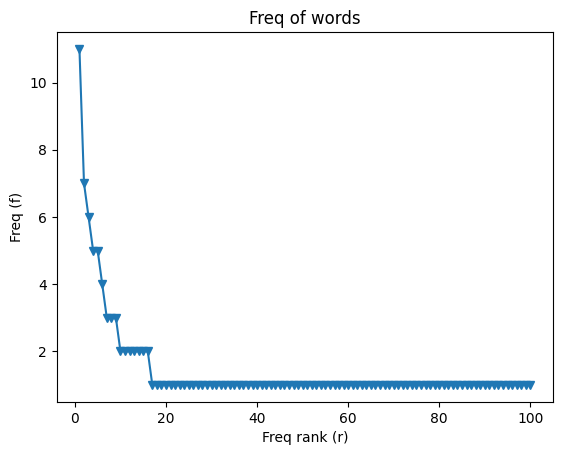

In [11]:
frequencies = get_frequencies(vocabulary, 100)
plot_frequencies(frequencies)

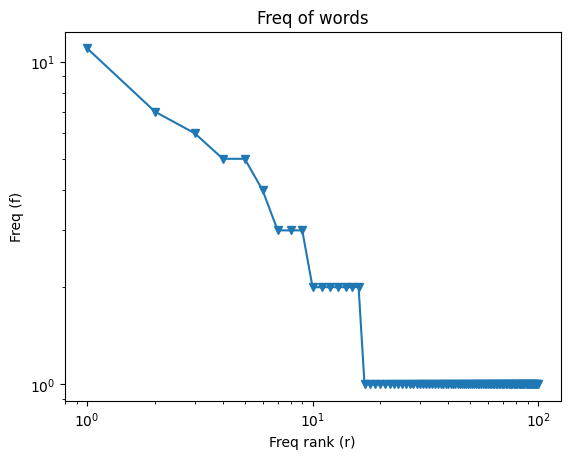

In [12]:
plot_frequencies(frequencies, log_scale=True)

**¿Qué pasará con más datos? 📊**

### Ley Zipf

Utilizaremos un corpus en español, entre más grande mejor.

In [37]:
dataset = load_dataset("wikimedia/wikipedia", "20231101.es", split="train", streaming=True)

In [38]:
dataset?

Type:        IterableDataset
String form:
IterableDataset({
    features: ['id', 'url', 'title', 'text'],
    num_shards: 13
})
File:        ~/develop/lectures/cl-2026-2-lab/.venv/lib/python3.12/site-packages/datasets/iterable_dataset.py
Docstring:   A Dataset backed by an iterable.

In [42]:
row = next(iter(dataset))

In [43]:
print(row["title"])
print(row["text"])

Andorra
Andorra, oficialmente Principado de Andorra () es un micro-Estado soberano sin litoral ubicado en el suroeste de Europa, entre España y Francia, en el límite de la península ibérica. Se constituye en Estado independiente, de derecho, democrático y social, cuya forma de gobierno es el coprincipado parlamentario. Su territorio está organizado en siete parroquias, con una población total de 79 877 habitantes a 28 de febrero de 2022. Su capital es Andorra la Vieja.

Con sus 468 km² de extensión territorial, Andorra es el micro-Estado más grande de Europa y está situado en los Pirineos, entre España y Francia; tiene una altitud media de 1996ms.n.m. Limita por el sur con España —con la provincia catalana de Lérida— y por el norte con Francia —con los departamentos de Ariège y Pirineos Orientales (Occitania)—. Pertenece culturalmente a la Europa latina.

Su sistema político es una democracia parlamentaria cuyos jefes de Estado son los copríncipes de Andorra: el obispo de Urgel y el pr

In [131]:
corpus = dataset.take(10000)

In [132]:
import re

def normalize_corpus(example):
    example["text"] = re.sub(r"[\W]", " ", example["text"])
    example["text"] = example["text"].lower()
    return example

In [142]:
from datasets.iterable_dataset import IterableDataset


def count_words(corpus: IterableDataset) -> Counter:
    word_counts = Counter()
    normalized_corpus = corpus.map(normalize_corpus)
    for row in normalized_corpus:
        text = row["text"]
        word_counts.update(text.split())
    return word_counts

In [144]:
%%time
words = count_words(corpus)

CPU times: user 9.98 s, sys: 380 ms, total: 10.4 s
Wall time: 19.9 s


In [145]:
words.most_common(10)

[('de', 1747227),
 ('la', 939980),
 ('en', 715451),
 ('el', 697480),
 ('y', 608372),
 ('que', 390315),
 ('a', 368981),
 ('los', 354029),
 ('del', 315715),
 ('se', 284080)]

In [146]:
import pandas as pd

def counter_to_pandas(counter: Counter) -> pd.DataFrame:
    df = pd.DataFrame.from_dict(counter, orient="index").reset_index()
    df.columns = ["word", "count"]
    df.sort_values("count", ascending=False, inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df

In [147]:
corpus_freqs = counter_to_pandas(words)

In [148]:
corpus_freqs.head(10)

,word,count
0,de,1747227
1,la,939980
2,en,715451
3,el,697480
4,y,608372
5,que,390315
6,a,368981
7,los,354029
8,del,315715
9,se,284080


In [149]:
corpus_freqs[corpus_freqs["word"] == "barriga"]

,word,count
60830,barriga,13


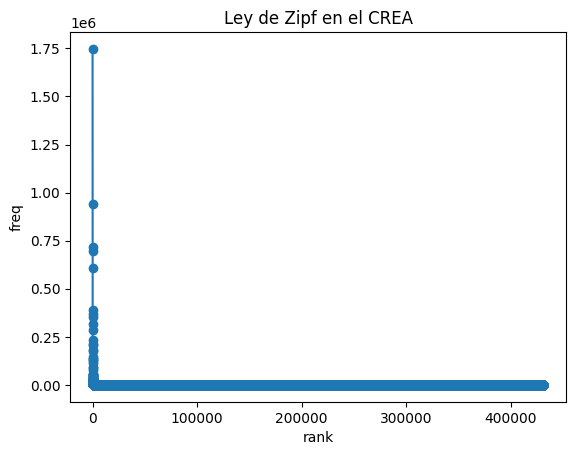

In [150]:
corpus_freqs["count"].plot(marker="o", legend=False)
plt.title('Ley de Zipf en el CREA')
plt.xlabel('rank')
plt.ylabel('freq')
plt.show()

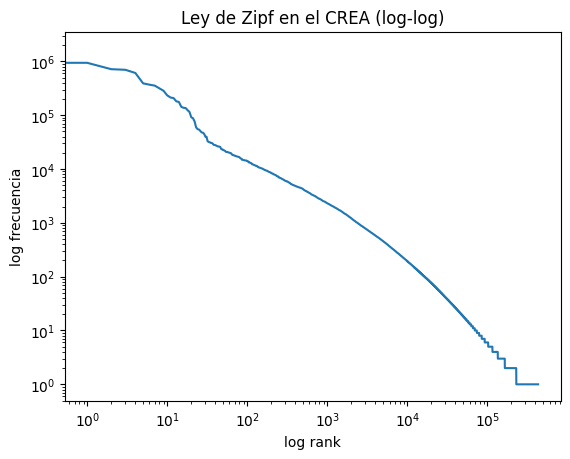

In [151]:
corpus_freqs['count'].plot(loglog=True, legend=False)
plt.title('Ley de Zipf en el CREA (log-log)')
plt.xlabel('log rank')
plt.ylabel('log frecuencia')
plt.show()

- Notamos que las frecuencias entre lenguas siguen un patrón
- Pocas palabras (tipos) son muy frecuentes, mientras que la mayoría de palabras ocurren pocas veces

De hecho, la frecuencia de la palabra que ocupa la posición r en el rank, es proporcional a $\frac{1}{r}$ (La palabra más frecuente ocurrirá aproximadamente el doble de veces que la segunda palabra más frecuente en el corpus y tres veces más que la tercer palabra más frecuente del corpus, etc)

$$f(w_r) \propto \frac{1}{r^α}$$

Donde:
- $r$ es el rank que ocupa la palabra en el corpus
- $f(w_r)$ es la frecuencia de la palabra en el corpus
- $\alpha$ es un parámetro, el valor dependerá del corpus o fenómeno que estemos observando

#### Formulación de la Ley de Zipf:

$f(w_{r})=\frac{c}{r^{\alpha }}$

En la escala logarítimica:

$log(f(w_{r}))=log(\frac{c}{r^{\alpha }})$

$log(f(w_{r}))=log (c)-\alpha log (r)$

#### ❓ ¿Cómo estimar el parámetro $\alpha$?

Podemos hacer una regresión lineal minimizando la suma de los errores cuadráticos:

$J_{MSE}=\sum_{r}^{}(log(f(w_{r}))-(log(c)-\alpha log(r)))^{2}$

In [154]:
from scipy.optimize import minimize

ranks = np.array(corpus_freqs.index) + 1
frecs = np.array(corpus_freqs['count'])

# Inicialización
a0 = 1

# Función de minimización:
func = lambda a: sum((np.log(frecs)-(np.log(frecs[0])-a*np.log(ranks)))**2)

# Apliando minimos cuadrados
a_hat = minimize(func, a0).x[0]

print('alpha:', a_hat, '\nMSE:', func(a_hat))

alpha: 1.1135615300454431 
MSE: 72159.91174172064


In [155]:
def plot_generate_zipf(alpha: np.float64, ranks: np.array, freqs: np.array) -> None:
    plt.plot(np.log(ranks),  np.log(freqs[0]) - alpha*np.log(ranks), color='r', label='Aproximación Zipf')

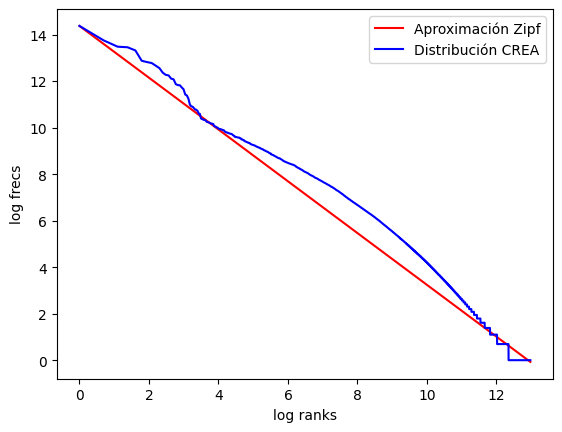

In [156]:
plot_generate_zipf(a_hat, ranks, frecs)
plt.plot(np.log(ranks),np.log(frecs), color='b', label='Distribución CREA')
plt.xlabel('log ranks')
plt.ylabel('log frecs')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

#### 📊 Ejercicio: Verificando ley de Zipf

- Busca un corpus en otra lengua (no español) en hugging face y descargalo
    - Si es muy grande toma una muestra
- Estima su parámetro $\alpha$
- Verifica a ojo de buen cubero si se cumple la ley de Zipf

### Ley de Heap

Relación entre el número de **tokens** y **tipos** de un corpus

$$T \propto N^b$$

Dónde:

- $T = $ número de tipos
- $N = $ número de tokens
- $b = $ parámetro  

- **TOKENS**: Número total de palabras dentro del texto (incluidas repeticiones)
- **TIPOS**: Número total de palabras únicas en el texto

#### 📊 Ejercicio: Muestra el plot de tokens vs types para el corpus CREA

**HINT:** Obtener tipos y tokens acumulados

## Diversidad lingũística 